In [1]:
!pip install botorch gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.3/738.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Defining `synthetic_stability_metric()`

In [2]:
import numpy as np

def synthetic_stability_metric(v):
    """
    Compute a synthetic grid stability metric (total voltage violations) for a 13-bus feeder.

    Parameters:
        v (array-like of length 13): Solar PV injection at each bus (1 through 13) in watts.

    Returns:
        int: Total count of voltage violations (voltage < 0.95 or > 1.05 p.u.)
             aggregated over a 10-step simulation of load/PV fluctuations.
    """
    # Ensure input is a NumPy array of length 13
    v = np.array(v, dtype=float).flatten()
    assert v.size == 13, "Input vector v must have length 13."

    # Base loads at each bus (in watts). Index 0 corresponds to bus1 (slack, no load).
    loads = np.array([0.0, 50e3, 30e3, 40e3, 20e3, 50e3, 20e3, 20e3, 10e3, 30e3, 20e3, 40e3, 50e3])

    # Define the feeder's radial topology (tree structure) via parent-child relationships.
    # children[parent_bus] = [list of child buses downstream of that parent].
    children = {
        1: [2],
        2: [3, 5],
        3: [4, 7],
        4: [9],
        5: [6],
        6: [12],
        7: [8],
        8: [13],
        9: [10, 11],
        10: [], 11: [], 12: [], 13: []
    }

    # Line impedance values (representative resistance) for each branch,
    # given as per-unit voltage drop per 100 kW of power flow.
    # Stored as R_line[child] = R for the line connecting (parent -> child).
    R_line = {
        2: 0.010,   # Line from bus1->bus2
        3: 0.015,   # bus2->bus3
        4: 0.015,   # bus3->bus4 (end of main feeder)
        5: 0.020,   # bus2->bus5 (start of a branch)
        6: 0.020,   # bus5->bus6
        7: 0.020,   # bus3->bus7 (start of another branch)
        8: 0.030,   # bus7->bus8
        9: 0.020,   # bus4->bus9 (branch off main feeder)
        10: 0.020,  # bus9->bus10
        11: 0.020,  # bus9->bus11
        12: 0.020,  # bus6->bus12 (end of branch off bus6)
        13: 0.030   # bus8->bus13 (end of branch off bus8)
    }

    # Line capacity (in watts) for each branch, above which congestion effects kick in.
    # Chosen such that ~6% voltage drop occurs at the capacity flow (i.e., at capacity, R_line*flow ≈ 0.06 p.u.).
    cap_line = {bus: (0.06 / R_line[bus]) * 100000.0 for bus in R_line}

    # Factor by which voltage drop is increased when branch flow exceeds capacity (simulating severe drops due to congestion).
    R_over_factor = 2.0

    # Voltage limits for stability (per unit)
    V_min = 0.95
    V_max = 1.05

    total_violations = 0  # initialize violation counter

    # Define 10 time-step scenarios for dynamic simulation (load and PV fluctuations).
    # We include worst-case extremes and random intermediate cases.
    rng = np.random.RandomState(0)  # fixed seed for reproducibility
    scenarios = [
        (0.2, 1.2),   # Step 1: 20% PV output, 120% load (cloudy peak-load scenario – likely undervoltage)
        (1.2, 0.8),   # Step 2: 120% PV output, 80% load (very sunny low-load scenario – likely overvoltage)
        (1.0, 1.0)    # Step 3: 100% PV, 100% load (balanced scenario – PV roughly equals local load)
    ]
    # Add 7 random scenarios (Step 4-10) with PV and load scaling factors in given ranges
    for _ in range(7):
        pv_scale   = rng.uniform(0.5, 1.1)  # PV output factor (50% to 110% of given v)
        load_scale = rng.uniform(0.9, 1.1)  # Load factor (90% to 110% of base load)
        scenarios.append((pv_scale, load_scale))

    # Simulate each time-step scenario
    for pv_scale, load_scale in scenarios:
        # Compute the effective PV injection and load at this time step
        injection = v * pv_scale    # PV output scaled by pv_scale
        load = loads * load_scale   # Load scaled by load_scale

        # Net power at each bus = load - injection (positive if net consumption, negative if net generation)
        # Use a dict for convenient access by bus number (buses indexed 1..13)
        net = {bus: load[bus-1] - injection[bus-1] for bus in range(1, 14)}

        # Recursively compute the total net power in each subtree of the feeder.
        subtree_net = {}
        def compute_subtree_net(node):
            """Return the sum of net power for all buses in the subtree rooted at `node`."""
            total = net[node]
            for child in children[node]:
                total += compute_subtree_net(child)
            subtree_net[node] = total
            return total

        # Compute subtree net for the entire feeder (starting from the root's children).
        # Bus 1 is the substation slack (root) – we start with its child (bus 2).
        for child in children[1]:  # (Typically just bus2 for this feeder)
            compute_subtree_net(child)
        # We can also compute bus1’s subtree net (which equals total feeder net plus bus1’s own net)
        subtree_net[1] = net[1] + sum(subtree_net[c] for c in children[1])

        # Compute voltage at each bus via a depth-first traversal from the substation (bus1).
        V = {}  # dictionary to store voltages per bus
        def assign_voltage(node, V_parent):
            """
            Assign voltage at `node` given parent voltage V_parent, using the power flow on the line (parent->node).
            Voltage drop is proportional to flow and line impedance, with extra drop if capacity is exceeded.
            """
            if node != 1:
                # Power flow on line from parent to this node (positive = flow into node, negative = flow out from node)
                P_flow = subtree_net[node]
                R = R_line[node]       # line resistance (p.u. per 100 kW)
                cap = cap_line[node]   # line capacity (W)
                P0 = 100000.0          # base power for scaling (100 kW)
                # Calculate normal voltage drop magnitude for this line
                flow = abs(P_flow)
                # Base drop for flow up to capacity
                base_flow = flow if flow <= cap else cap
                drop_base = R * (base_flow / P0)
                # Additional drop if flow exceeds capacity (congestion penalty)
                drop_extra = 0.0
                if flow > cap:
                    drop_extra = R_over_factor * R * ((flow - cap) / P0)
                total_drop = drop_base + drop_extra
                # Apply drop or rise depending on flow direction:
                if P_flow >= 0:
                    # Positive flow (net load downstream): voltage drops moving downstream
                    V[node] = V_parent - total_drop
                else:
                    # Negative flow (net generation downstream): current flows upstream, causing a voltage rise at this node
                    V[node] = V_parent + total_drop
            else:
                # Bus 1 is the slack (substation) with fixed voltage ~1.0 p.u.
                V[node] = V_parent
            # Recurse for all children of this node
            for child in children[node]:
                assign_voltage(child, V[node])

        # Start voltage assignment from the root (bus1) at 1.0 p.u.
        assign_voltage(node=1, V_parent=1.0)

        # Count voltage violations at this time step (excluding bus1 which is held at 1.0 p.u.)
        for bus in range(2, 14):
            if V[bus] < V_min or V[bus] > V_max:
                total_violations += 1

    return int(total_violations)


### Vanilla BO

In [4]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.logei import qLogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood

import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Define objective as penalized `synthetic_stability_metric()` function
max_capacity = 1e5 # 10 kW capacity max

def objective(v: torch.Tensor) -> torch.Tensor:
    penalty = 0 #(v.sum(dim=-1) > 1).float() * 1e6
    results = []
    for vec in v:
        score = synthetic_stability_metric(vec.detach().numpy()*max_capacity)
        results.append(score)
    return -(torch.tensor(results).float().unsqueeze(-1) )#+ penalty.unsqueeze(-1))

In [6]:
# Initial design
dim = 13

# Deifne dirichlet distribution to draw initial samples from
# n_initial = 20
# dirichlet = torch.distributions.Dirichlet(torch.ones(dim))
# weights = dirichlet.sample((n_initial,))

# train_x = (weights * torch.rand(n_initial, 1)).double()
# train_obj = objective(train_x).double()

from botorch.utils.sampling import draw_sobol_samples
bounds = torch.tensor([[0.0] * dim, [1] * dim])
train_x_vanilla = draw_sobol_samples(bounds=bounds, n=10, q=1).squeeze(1).double()
train_obj = objective(train_x_vanilla).double()
print(train_obj)

tensor([[-88.],
        [-27.],
        [-77.],
        [-16.],
        [-51.],
        [-55.],
        [-81.],
        [-32.],
        [-38.],
        [-65.]], dtype=torch.float64)


In [ ]:
# BO loop
n_iterations = 100
best_values = []
for i in range(n_iterations):
    # Fit GP model
    model = SingleTaskGP(train_x_vanilla, train_obj)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # Best value so far (maximize -f)
    best_f = train_obj[train_obj < 0].max().item()

    # Acquisition function
    acq_func = qLogExpectedImprovement(model=model, best_f=best_f)

    # Optimize in unit simplex (sum x_i <= 1)
    inequality_constraints = [(torch.arange(dim), torch.ones(dim), 1.0)]

    candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=10,
        raw_samples=128,
        #inequality_constraints=inequality_constraints
    )

    # Evaluate real objective (not negated)
    y_new = objective(candidate).double()  # negate for minimization
    #print(f"{candidate=}")
    # Update training data
    train_x_vanilla = torch.cat([train_x_vanilla, candidate], dim=0)
    train_obj = torch.cat([train_obj, y_new], dim=0)

    best_obj = train_obj.max().item()
    best_values.append(best_obj)

    #print(f"Iter {i+1}: {best_obj=}")

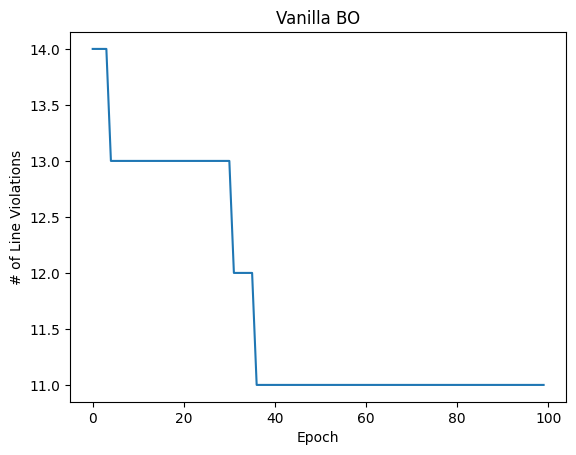

In [ ]:
plt.plot([-value for value in best_values])
plt.title("Vanilla BO")
plt.ylabel("# of Line Violations")
plt.xlabel("Epoch")
plt.show()

In [ ]:
best_vanilla = train_x_vanilla[0]
best_vanilla_obj = objective(best_vanilla.unsqueeze(0)).item()

for v in train_x_vanilla:
    v_obj = objective(v.unsqueeze(0)).item()
    if v_obj > best_vanilla_obj:
        best_vanilla = v
        best_vanilla_obj = v_obj

print(best_vanilla*max_capacity, best_vanilla_obj)


tensor([ 39073.9471,  34184.0178,      0.0000,  41915.2886, 100000.0000,
         22222.6426,  13304.7923,  81303.4236,      0.0000,   8727.9439,
         24611.8098,  37378.6062,  12358.5247], dtype=torch.float64) -11.0


### SAASBO

In [ ]:
!pip install -U botorch

In [ ]:
import torch
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
from botorch.fit import fit_fully_bayesian_model_nuts
from botorch.acquisition.logei import qLogExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler
from botorch.optim import optimize_acqf
from botorch.utils.sampling import draw_sobol_samples

In [ ]:
# Configuration
dim = 13
bounds = torch.stack([torch.zeros(dim), torch.ones(dim)])
n_initial_points = 10
n_iterations = 10

# Initial design
train_x = draw_sobol_samples(bounds=bounds, n=n_initial_points, q=1).squeeze(1).double()
train_obj = objective(train_x).double()
best_saasbo_values = []

# Optimization loop
for i in range(n_iterations):
    print(f"Iteration {i+1}")

    # Fit SAAS model
    model = SaasFullyBayesianSingleTaskGP(train_x, train_obj)
    fit_fully_bayesian_model_nuts(model)

    # Acquisition function
    sampler = SobolQMCNormalSampler(sample_shape=torch.Size([128]))
    # Best value so far (maximize -f)
    best_f = train_obj[train_obj < 0].max().item()
    acq_func = qLogExpectedImprovement(model=model, best_f = best_f)

    # Optimize acquisition function
    candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=10,
        raw_samples=128,
    )

    # Evaluate new candidate
    y_new = objective(candidate).double()
    print(f"  New obj: {y_new.item():.4f}")

    # Update training data
    train_x = torch.cat([train_x, candidate], dim=0)
    train_obj = torch.cat([train_obj, y_new], dim=0)

    # Report best value so far
    best = train_obj.max().item()
    best_saasbo_values.append(best)
    print(f"  Best obj so far: {best:.4f}")

/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([18.7617], dtype=torch.float64), mean = tensor([-51.], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 1


Sample: 100%|██████████| 768/768 [01:48,  7.06it/s, step size=3.09e-01, acc. prob=0.911]
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([18.6079], dtype=torch.float64), mean = tensor([-49.3636], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


  New obj: -33.0000
  Best obj so far: -19.0000
Iteration 2


Sample: 100%|██████████| 768/768 [01:54,  6.68it/s, step size=2.80e-01, acc. prob=0.912]
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([17.7551], dtype=torch.float64), mean = tensor([-49.1667], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


  New obj: -47.0000
  Best obj so far: -19.0000
Iteration 3


Sample: 100%|██████████| 768/768 [02:28,  5.16it/s, step size=1.85e-01, acc. prob=0.927]
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([17.5572], dtype=torch.float64), mean = tensor([-50.3846], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


  New obj: -65.0000
  Best obj so far: -19.0000
Iteration 4


Sample: 100%|██████████| 768/768 [02:17,  5.59it/s, step size=1.97e-01, acc. prob=0.940]
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([19.2388], dtype=torch.float64), mean = tensor([-52.8571], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


  New obj: -85.0000
  Best obj so far: -19.0000
Iteration 5


Sample: 100%|██████████| 768/768 [02:14,  5.71it/s, step size=1.95e-01, acc. prob=0.936]
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([18.9317], dtype=torch.float64), mean = tensor([-51.8667], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


  New obj: -38.0000
  Best obj so far: -19.0000
Iteration 6


Sample: 100%|██████████| 768/768 [02:19,  5.52it/s, step size=2.04e-01, acc. prob=0.954]
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([18.7150], dtype=torch.float64), mean = tensor([-50.8750], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


  New obj: -36.0000
  Best obj so far: -19.0000
Iteration 7


Sample: 100%|██████████| 768/768 [02:33,  5.01it/s, step size=1.57e-01, acc. prob=0.950]
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([18.1483], dtype=torch.float64), mean = tensor([-51.1176], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


  New obj: -55.0000
  Best obj so far: -19.0000
Iteration 8


Sample: 100%|██████████| 768/768 [02:48,  4.55it/s, step size=1.72e-01, acc. prob=0.926]
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([19.0730], dtype=torch.float64), mean = tensor([-49.3889], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


  New obj: -20.0000
  Best obj so far: -19.0000
Iteration 9


Sample: 100%|██████████| 768/768 [02:55,  4.37it/s, step size=1.46e-01, acc. prob=0.932]
/usr/local/lib/python3.11/dist-packages/botorch/models/utils/assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([18.6406], dtype=torch.float64), mean = tensor([-49.8421], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


  New obj: -58.0000
  Best obj so far: -19.0000
Iteration 10


Sample: 100%|██████████| 768/768 [02:13,  5.77it/s, step size=3.85e-01, acc. prob=0.900]


  New obj: -26.0000
  Best obj so far: -19.0000


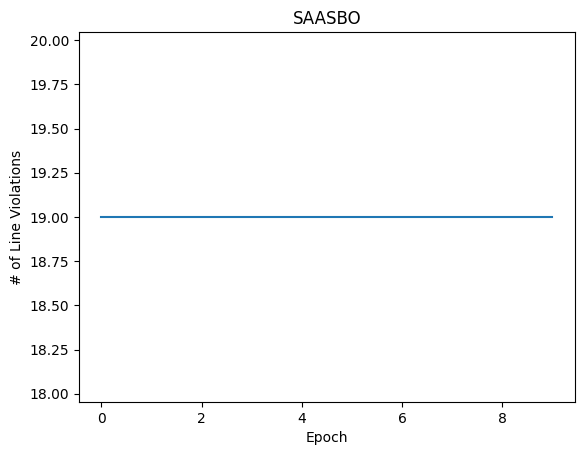

In [ ]:
plt.plot([-value for value in best_saasbo_values])
plt.title("SAASBO")
plt.ylabel("# of Line Violations")
plt.xlabel("Epoch")
plt.show()

### Multiobjective BO

In [ ]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.multi_objective import ExpectedHypervolumeImprovement
from botorch.utils.multi_objective.box_decompositions.non_dominated import NondominatedPartitioning
from botorch.optim import optimize_acqf
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize
from botorch.models.model_list_gp_regression import ModelListGP

In [ ]:
# Problem setup
dim = 13  # Input dimensions
num_objectives = 2  # Number of objectives
n_init = 10  # Number of initial points
n_iterations = 30  # Number of optimization iterations

# Define bounds for the search space
bounds = torch.stack([torch.zeros(dim), torch.ones(dim)]).double()

# Define objective functions (you need to define these)
def building_cost(v: torch.Tensor) -> torch.Tensor:
    results = []
    for vec in v:
        active_mask = vec > 1e-3
        fixed_cost = 500_000 * active_mask.sum().item()
        variable_cost = vec.sum().item()*max_capacity
        total_cost = fixed_cost + variable_cost
        results.append(total_cost)
    return torch.tensor(results).float().unsqueeze(-1)

# Define combined multiobjective function
def multiobjective_function(X):
    cost = building_cost(X).view(-1, 1)  # Make it 2D
    obj = objective(X).view(-1, 1)       # Make it 2D
    return torch.cat([-cost, obj], dim=-1)  # Negative cost for maximization

# Initial sampling
# Ensure float32 dtype
train_X = 0.2*draw_sobol_samples(bounds=bounds, n=n_init, q=1).squeeze(1).to(torch.float32)
train_Y = multiobjective_function(train_X)

# Make sure ref_point is same dtype as train_Y
ref_point = torch.zeros(2, dtype=train_Y.dtype)

# Optimization loop
for iteration in range(n_iterations):
    # 1. Fit models for each objective
    models = []
    for i in range(num_objectives):
        # Standardize outputs for better numerical performance
        # Extract the objective values for this specific objective
        train_Y_i = train_Y[:, i].unsqueeze(-1)  # Keep as 2D tensor

        # Standardize these values (outputs standard deviation of 1)
        std_train_Y_i = standardize(train_Y_i)

        # Define and fit GP model
        model_i = SingleTaskGP(train_X.double(), std_train_Y_i.double())
        mll_i = ExactMarginalLogLikelihood(model_i.likelihood, model_i)
        fit_gpytorch_mll(mll_i)
        models.append(model_i)

    # 2. Define acquisition function
    # Create a partitioning of the non-dominated space
    partitioning = NondominatedPartitioning(ref_point=ref_point, Y=train_Y)

    # Create EHVI acquisition function
    model = ModelListGP(*models)
    model.eval()

    acq_func = ExpectedHypervolumeImprovement(
        model=model,
        ref_point=ref_point,
        partitioning=partitioning
    )

    # 3. Optimize acquisition function
    candidate, acq_value = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=2,  # Batch size
        num_restarts=20,
        raw_samples=1024,
    )

    # Ensure candidate has the same dtype as train_X
    candidate = candidate.to(train_X.dtype)

    # 4. Evaluate new candidate
    new_Y = multiobjective_function(candidate)

    # 5. Update training data
    train_X = torch.cat([train_X, candidate])
    train_Y = torch.cat([train_Y, new_Y])

    # Print progress - here we're showing the best values for each objective separately
    best_values = []
    for i in range(num_objectives):
        # For first objective (cost) we want minimum (maximum of negative)
        # For second objective we want maximum
        best_values.append(train_Y[:, i].max().item())

    print(f"Iteration {iteration+1}/{n_iterations}: Best values = {best_values}")

# Extract Pareto front
pareto_mask = torch.ones(train_Y.shape[0], dtype=torch.bool)
for i in range(train_Y.shape[0]):
    for j in range(train_Y.shape[0]):
        if i != j and torch.all(train_Y[j] >= train_Y[i]) and torch.any(train_Y[j] > train_Y[i]):
            pareto_mask[i] = False
            break

pareto_X = train_X[pareto_mask]
pareto_Y = train_Y[pareto_mask]

print("Optimization complete!")
print(f"Found {pareto_Y.shape[0]} Pareto-optimal points")

/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 1/30: Best values = [-6085180.0, -61.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 2/30: Best values = [-5714944.5, -35.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 3/30: Best values = [-5714944.5, -14.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 4/30: Best values = [-5714944.5, -12.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 5/30: Best values = [-5263889.5, -12.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 6/30: Best values = [-5263889.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 7/30: Best values = [-4789390.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 8/30: Best values = [-4789390.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 9/30: Best values = [-4789390.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 10/30: Best values = [-4789390.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 11/30: Best values = [-4789390.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 12/30: Best values = [-4789390.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 13/30: Best values = [-3758646.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 14/30: Best values = [-3758646.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 15/30: Best values = [-3758646.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 16/30: Best values = [-3758646.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 17/30: Best values = [-3758646.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 18/30: Best values = [-3758646.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 19/30: Best values = [-3758646.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 20/30: Best values = [-3758646.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 21/30: Best values = [-3758646.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 22/30: Best values = [-3758646.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 23/30: Best values = [-3758646.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 24/30: Best values = [-3758646.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 25/30: Best values = [-3296084.75, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 26/30: Best values = [-3296084.75, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 27/30: Best values = [-3277889.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 28/30: Best values = [-3277889.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 29/30: Best values = [-3277889.5, -11.0]


/usr/local/lib/python3.11/dist-packages/botorch/acquisition/multi_objective/analytic.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


Iteration 30/30: Best values = [-3277889.5, -11.0]
Optimization complete!
Found 2 Pareto-optimal points


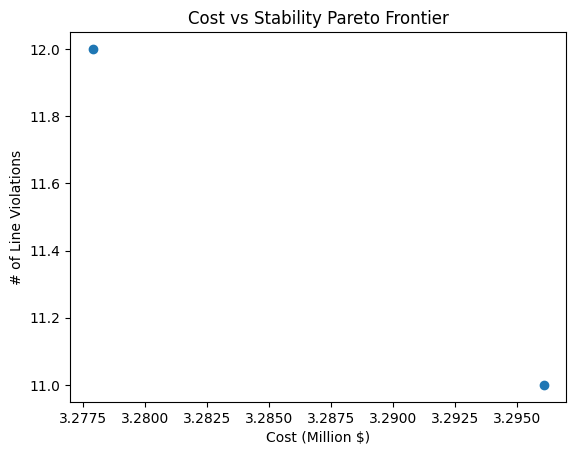

tensor([[-3.2961e+06, -1.1000e+01],
        [-3.2779e+06, -1.2000e+01]])


In [ ]:
plt.scatter(-pareto_Y[:,0]/1000000, -pareto_Y[:,1])
plt.xlabel("Cost (Million $)")
plt.ylabel("# of Line Violations")

plt.title("Cost vs Stability Pareto Frontier")
plt.show()
print(pareto_Y)

### Sparse Bayesian Optimization

In [7]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.multi_objective.monte_carlo import (
    qNoisyExpectedHypervolumeImprovement,
)
from botorch.sampling import SobolQMCNormalSampler
from botorch.optim import optimize_acqf
from botorch.utils.multi_objective.hypervolume import Hypervolume

ImportError: cannot import name 'fit_gpytorch_model' from 'botorch.fit' (/usr/local/lib/python3.11/dist-packages/botorch/fit.py)

In [ ]:
# --- SEBO-style (objective + sparsity) Bayesian-optimisation loop -------------
# assumes `objective`, `train_x_vanilla`, `train_obj`, `dim`, `bounds` already
# defined exactly as in your snippet above


tkwargs = {"dtype": torch.double, "device": train_x_vanilla.device}

# helper: L0 sparsity (number of non-zero dims, threshold 1e-3)
def l0(x: torch.Tensor, tol: float = 1e-3) -> torch.Tensor:
    return (x.abs() > tol).sum(dim=-1, keepdim=True).double()

# combine objective and sparsity
train_Y = torch.cat(
    [
        train_obj,                 # maximise synthetic_stability_metric (negated)
        -l0(train_x_vanilla)       # maximise (-L0)  ⇒ fewer active dims preferred
    ],
    dim=-1,
)

def fit_model(X, Y):
    gp = SingleTaskGP(X, Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
    return gp

model = fit_model(train_x_vanilla, train_Y)

# reference point below the current observed min for each objective
ref_point = train_Y.min(dim=0).values - 1.0

N_BATCHES, BATCH_SIZE = 30, 1   # tweak as needed
sampler = SobolQMCNormalSampler(num_samples=128)

for i in range(N_BATCHES):
    # acquisition = SEBO ≈ NEHVI on [objective, –L0]
    acqf = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=ref_point.tolist(),
        X_baseline=train_x_vanilla,
        prune_baseline=True,
        sampler=sampler,
    )

    cand, _ = optimize_acqf(
        acq_function=acqf,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=10,
        raw_samples=256,
    )

    # evaluate objectives
    y_obj = objective(cand).double()
    y_sparse = -l0(cand)
    new_Y = torch.cat([y_obj, y_sparse], dim=-1)

    # update data
    train_x_vanilla = torch.cat([train_x_vanilla, cand], dim=0)
    train_Y = torch.cat([train_Y, new_Y], dim=0)

    # refit GP
    model = fit_model(train_x_vanilla, train_Y)

    # (optional) track hyper-volume
    hv = Hypervolume(ref_point)
    print(
        f"Iter {i+1:02d} |  HV = {hv.compute(train_Y):.3f} | "
        f"best obj={train_Y[:,0].max():.3f} at sparsity ≤{int((-train_Y[:,1]).min())}"
    )